In [1]:
import pandas as pd
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from statistics import mean, stdev
import pickle
import numpy as np
from transformers import AutoTokenizer

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def hhrlhf_preproc(inp, out):
    resp = inp
    if "###Human: " not in inp: 
        resp = "###Human: "+inp
    if "###Assistant: " not in out: 
        resp = resp+" ###Assistant: "
    resp = resp+out
    return resp

def pp_hh(ex): 
    ex['question'] = ex['chosen'].rsplit("\n\nAssistant: ")[0]
    
    ex['response_j'] = ex['chosen'].replace("\n\n", " ###").rsplit("###Assistant: ")[1]
    ex['response_k'] = ex['rejected'].replace("\n\n", " ###").rsplit("###Assistant: ")[1]
    return ex

def pp_uf(ex):
    ex['chosen'] = "###Human: "+ex['question'].strip()+" ###Assistant: "+ex['response_j']
    ex['rejected'] = "###Human: "+ex['question'].strip()+" ###Assistant: "+ex['response_k']
    return ex

def fin_accs(chos, rejs):
    rlast = [r[-1] for r in rejs]
    clast = [c[-1] for c in chos]
    return sum([clast[i]>rlast[i] for i in range(len(rejs))])

def lenbias(chos, rejs):
    return sum([len(chos[i])>len(rejs[i]) for i in range(len(rejs))])

In [3]:
# Code for loading in data
hh_train = load_dataset("Anthropic/hh-rlhf", data_dir="helpful-base", split="test").map(pp_hh, num_proc=10)
ultrafeediff = Dataset.load_from_disk("../../data/ultra/ultrafeeddiff/").shuffle(seed=0).select(range(1000)).filter(lambda ex: ex['tokj']<150).map(pp_uf)

Found cached dataset json (/u/prasanns/.cache/huggingface/datasets/Anthropic___json/Anthropic--hh-rlhf-37c6f75e35564d2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)
Loading cached processed dataset at /u/prasanns/.cache/huggingface/datasets/Anthropic___json/Anthropic--hh-rlhf-37c6f75e35564d2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e0015313a1c7148d_*_of_00010.arrow
Loading cached shuffled indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultra/ultrafeeddiff/cache-5898f0ebaad14ffe.arrow
Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultra/ultrafeeddiff/cache-45b182770748902d.arrow
Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ultra/ultrafeeddiff/cache-472f00fcfc1cacab.arrow


In [5]:
utok = AutoTokenizer.from_pretrained("openbmb/UltraRM-13b")
debtok = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")
opttok = AutoTokenizer.from_pretrained("facebook/opt-125m")

In [75]:
with open('uf13b_uf_indistr.pkl', 'rb') as file:
    ultrachos, ultrarejs = pickle.load(file)

with open('l3b_uf_indistr.pkl', 'rb') as file:
    l3bchos, l3rejs = pickle.load(file)

with open('deberta_openassist_ufdata.pkl', 'rb') as file:
    debchos, debrejs = pickle.load(file)

In [15]:
with open('boweven_ultrascos.pkl', 'rb') as file:
    ultrachos, ultrarejs = pickle.load(file)

In [187]:
with open('ultra13b.pkl', 'rb') as file:
    ultrachos, ultrarejs = pickle.load(file)

with open('l3b_uf_hhrlhf.pkl', 'rb') as file:
    l3bchos, l3rejs = pickle.load(file)

with open('deberta_openassist_hhdata.pkl', 'rb') as file:
    debchos, debrejs = pickle.load(file)

In [161]:
fin_accs(l3bchos, l3rejs)

45

In [10]:
def step_stats(scolist):
    # go up to the end
    rlens = [len(l) for l in scolist]
    means = []
    vars = []
    for i in range(max(rlens)):
        tmpd = []
        for j in range(len(scolist)):
            if rlens[j]>i:
                tmpd.append(scolist[j][i])
        means.append(mean(tmpd))
        try:
            vars.append(stdev(tmpd))
        except: 
            vars.append(0)
    return means, vars

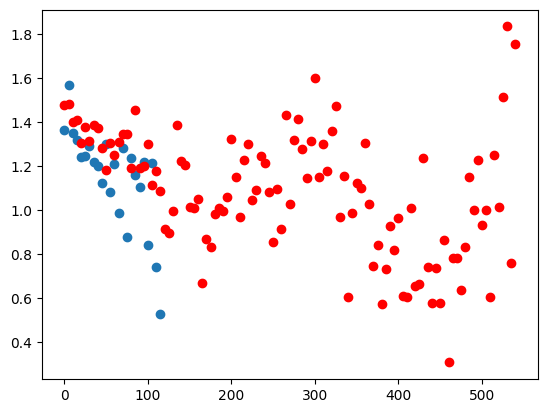

In [16]:
msc, vsc = step_stats(ultrachos)
msr, vsr = step_stats(ultrarejs)
plt.scatter(list(range(0, len(msc)*5, 5)), msc)
plt.scatter(list(range(0, len(msr)*5, 5)), msr, color='r')

In [7]:
def wordplot(inpstr, scosa, scosb, scosc): 
    # Function to plot scores
    def plot_scores(tokens, scores, label, marker):
        positions = range(len(tokens))  # Position for each token
        plt.scatter(positions, scores, label=label, marker=marker)
    
    plt.figure(figsize=(15, 6))
    tokens_func1 = tokenizer1.tokenize(text)
    tokens_func2 = tokenizer2.tokenize(text)
    tokens_func3 = tokenizer3.tokenize(text)
    # Plot for each tokenizer
    plot_scores(tokens_func1, normalized_scores1, 'Tokenizer 1 (BERT)', 'o')
    plot_scores(tokens_func2, normalized_scores2, 'Tokenizer 2 (GPT-2)', 's')
    plot_scores(tokens_func3, normalized_scores3, 'Tokenizer 3 (RoBERTa)', '^')
    
    # Customize the plot
    plt.xlabel("Token positions")
    plt.ylabel("Normalized Scores")
    plt.title("Token Scores by Different Tokenizers")
    plt.legend()
    plt.show()

In [8]:
def wordscoplots(question, text, scos, tok, label):
    print(question)
    tokens = tok(text)
    
    # Group tokens in groups of 5
    def group_tokens(tokens):
        return [' '.join(tok.decode(tokens.input_ids[i:i+5], skip_special_tokens=True)) for i in range(0, len(tokens.input_ids), 5)]
    
    grouped_tokens1 = group_tokens(tokens)
    
    print(len(scos))
    print(len(grouped_tokens1))
    
    grouped_tokens1 = grouped_tokens1[:len(scos)]
    # Example scores (replace with your actual scores)
    scos = scos[:len(grouped_tokens1)]
    scos = [s - min(scos) for s in scos]
    scos = [s/(max(scos)+0.01) for s in scos]
    # Normalize the scores
    max_score1 = max(scores_func1, default=1)
    
    normalized_scores1 = scos
    
    # Function to plot scores
    def plot_scores(tokens, scores, label, marker):
        plt.scatter(tokens, scores, label=label, marker=marker)
    
    plt.figure(figsize=(15, 6))

    #print(len(grouped_tokens1), len(normalized_scores1))
    # Plot for each tokenizer
    plot_scores(grouped_tokens1, normalized_scores1, label, 'o')
    #plot_scores(grouped_tokens2, normalized_scores2, 'Tokenizer 2', 's')
    #plot_scores(grouped_tokens3, normalized_scores3, 'Tokenizer 3', '^')
    
    # Customize the plot
    plt.xticks(rotation=45)
    plt.xlabel("Token Groups (5 tokens each)")
    plt.ylabel("Normalized Scores")
    plt.title("Token Scores by Different Tokenizers for 5-Token Groups")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [185]:
scosdict = {
    'c':{
        'u13b':ultrachos, 
        'l3b':l3bchos,
        'deb':debchos
    },
    'r':{
        'u13b':ultrarejs, 
        'l3b':l3rejs,
        'deb':debrejs
    } 
}
toks = {
    'u13b':utok, 
    'l3b':utok,
    'deb':debtok
}



Human: I want to make a pumpkin pie for Thanksgiving, but I've never made one before.  How do I make a pumpkin pie?
13
13


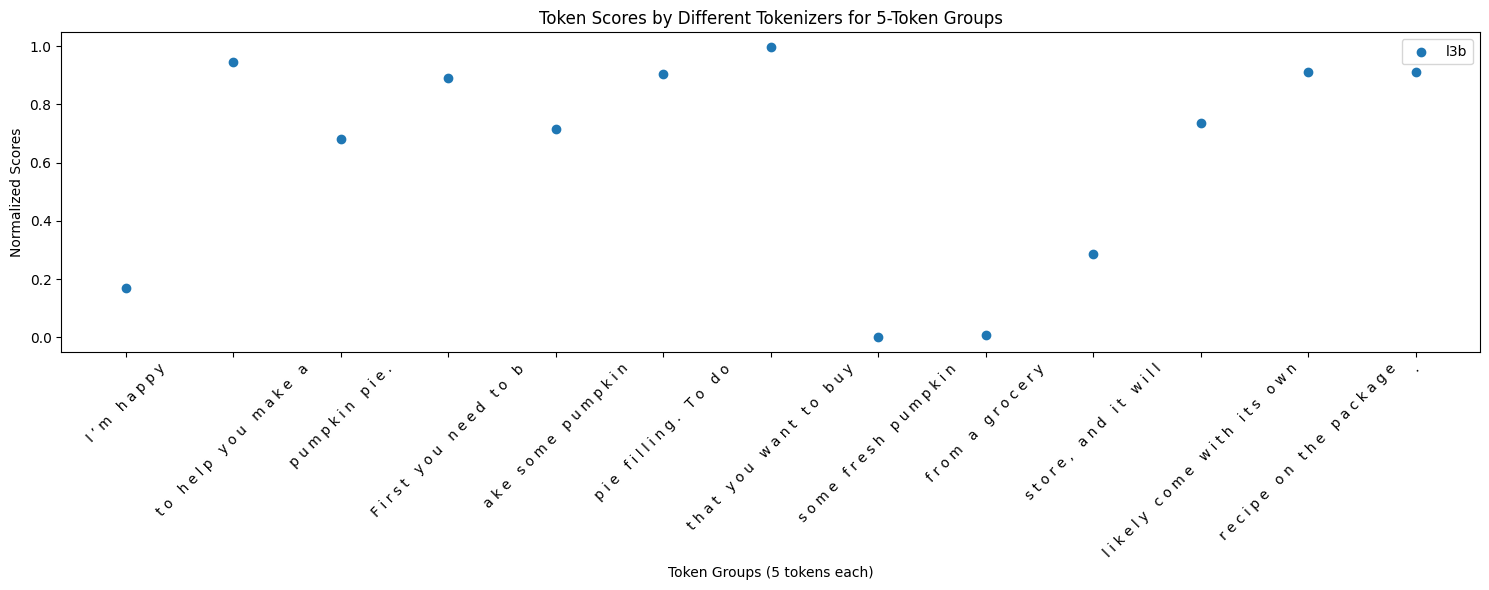

In [226]:
ind = 10
chosen = 'r'
set = 'l3b'
row = hh_train[ind]

wordscoplots(row['question'], row['response_j'] if chosen=='c' else row['response_k'], scosdict[chosen][set][ind], toks[set], set)

In [170]:
hh_train

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 2354
})